In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv(
    "C:/Users/Matias/OneDrive/Documentos/jupyter/CausalAI-Course/data/processed.cleveland.data",
    header=None
)

df.columns = [
    'age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'
]

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df = df.replace('?', np.nan)

df = df.astype(float)

df = df.dropna()

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


In [4]:
df['y'] = np.where(df['hd'] > 0, 1, 0)

In [5]:
categorical_vars = [
    'sex',       # 1 = hombre, 0 = mujer
    'cp',        # tipo de dolor de pecho
    'fbs',       # glucosa en ayunas > 120 mg/dl
    'restecg',   # resultado electrocardiograma
    'exang',     # angina inducida por ejercicio
    'slope',     # pendiente del segmento ST
    'ca',        # número de vasos coloreados
    'thal'       # resultado del escaneo con talio
]

In [6]:
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
df.head()

,age,restbp,chol,thalach,oldpeak,hd,y,sex_1.0,cp_2.0,cp_3.0,...,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,0.0,0,True,False,False,...,False,True,False,False,True,False,False,False,True,False
1,67.0,160.0,286.0,108.0,1.5,2.0,1,True,False,False,...,False,True,True,True,False,False,False,True,False,False
2,67.0,120.0,229.0,129.0,2.6,1.0,1,True,False,False,...,False,True,True,True,False,False,True,False,False,True
3,37.0,130.0,250.0,187.0,3.5,0.0,0,True,False,True,...,False,False,False,False,True,False,False,False,False,False
4,41.0,130.0,204.0,172.0,1.4,0.0,0,False,True,False,...,False,True,False,False,False,False,False,False,False,False


In [28]:
drop_cols = ['y']
if 'hd' in df.columns:
    drop_cols.append('hd')

X = df.drop(columns=drop_cols)
y = df['y']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, random_state=123, stratify=y
)

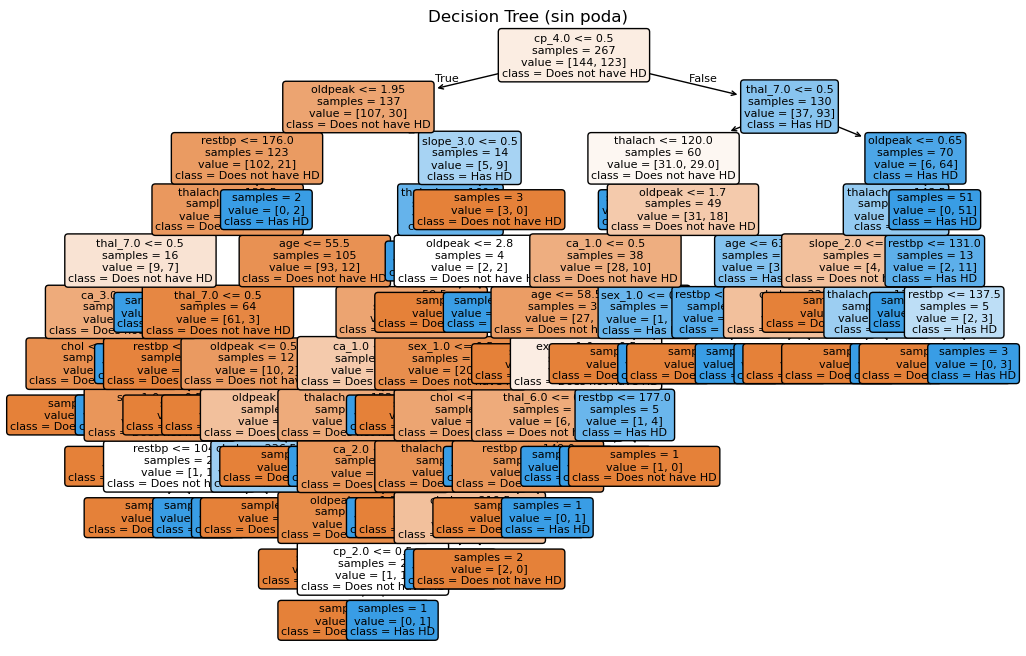

In [30]:
tree = DecisionTreeClassifier(random_state=123)
tree.fit(X_train, y_train)

plt.figure(figsize=(12,8))
_ = plot_tree(tree, feature_names=X.columns, class_names=["Does not have HD", "Has HD"],
              filled=True, rounded=True, impurity=False, fontsize=8)
plt.title("Decision Tree (sin poda)")
plt.show()


In [31]:
y_pred = tree.predict(X_test)
acc_unpruned = (y_pred == y_test).mean()
print(f"Accuracy (árbol sin poda): {acc_unpruned:.3f}")

Accuracy (árbol sin poda): 0.800


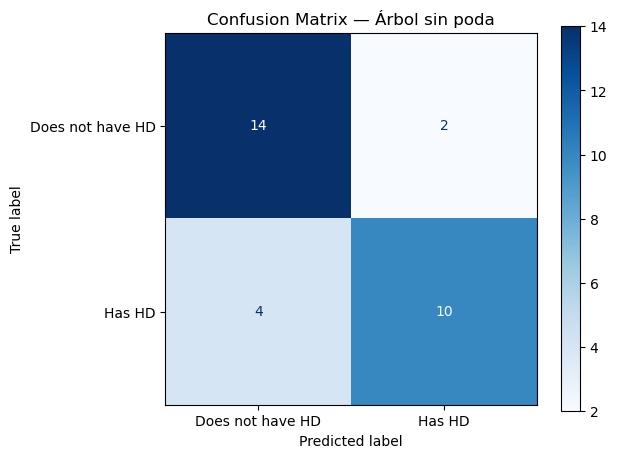

Classification report (árbol sin poda):
                  precision    recall  f1-score   support

Does not have HD       0.78      0.88      0.82        16
          Has HD       0.83      0.71      0.77        14

        accuracy                           0.80        30
       macro avg       0.81      0.79      0.80        30
    weighted avg       0.80      0.80      0.80        30



In [32]:
labels = ["Does not have HD", "Has HD"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix — Árbol sin poda")
plt.show()

print("Classification report (árbol sin poda):")
print(classification_report(y_test, y_pred, target_names=labels))

In [43]:
print("Predicted HD right:",cm[1,1], ",Predicted no HD wrong:",cm[1,0], ",Predicted HD wrong:",cm[0,1], ",Predicted no HD right:", cm[0,0])
print("Predicted right:",(cm[1,1]+cm[0,0])*100/30,"   ","Predicted wrong:",(cm[0,1]+cm[1,0])*100/30)

Predicted HD right: 10 ,Predicted no HD wrong: 4 ,Predicted HD wrong: 2 ,Predicted no HD right: 14
Predicted right: 80.0     Predicted wrong: 20.0


In [38]:
alphas = np.exp(np.linspace(-10, np.log(0.05), 50))

In [39]:
folds = KFold(n_splits=4, shuffle=True, random_state=123)
inaccuracies = np.zeros_like(alphas)

for i, alpha in enumerate(alphas):
    tree_cv = DecisionTreeClassifier(ccp_alpha=alpha, random_state=123)
    results = cross_validate(tree_cv, X_train, y_train, cv=folds, scoring="accuracy", n_jobs=-1)
    inaccuracies[i] = 1 - results["test_score"].mean()

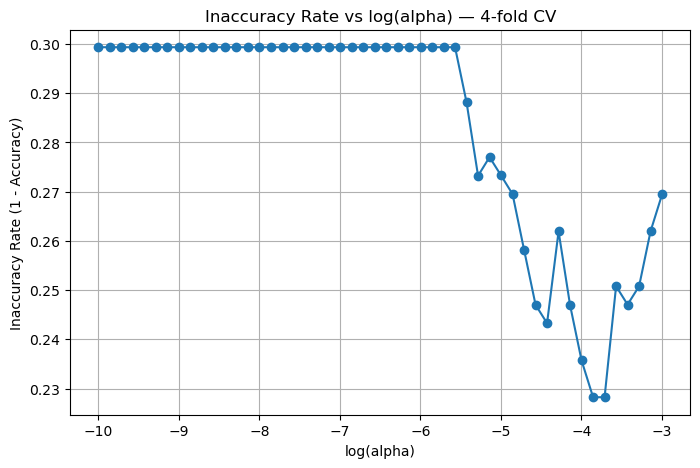

In [44]:
plt.figure(figsize=(8,5))
plt.plot(np.log(alphas), inaccuracies, marker='o')
plt.xlabel("log(alpha)")
plt.ylabel("Inaccuracy Rate (1 - Accuracy)")
plt.title("Inaccuracy Rate vs log(alpha) — 4-fold CV")
plt.grid(True)
plt.show()

In [45]:
optimal_alpha = alphas[np.argmin(inaccuracies)]
print(f"Optimal alpha (ccp_alpha) encontrado por CV: {optimal_alpha:.6g}")

Optimal alpha (ccp_alpha) encontrado por CV: 0.0212076


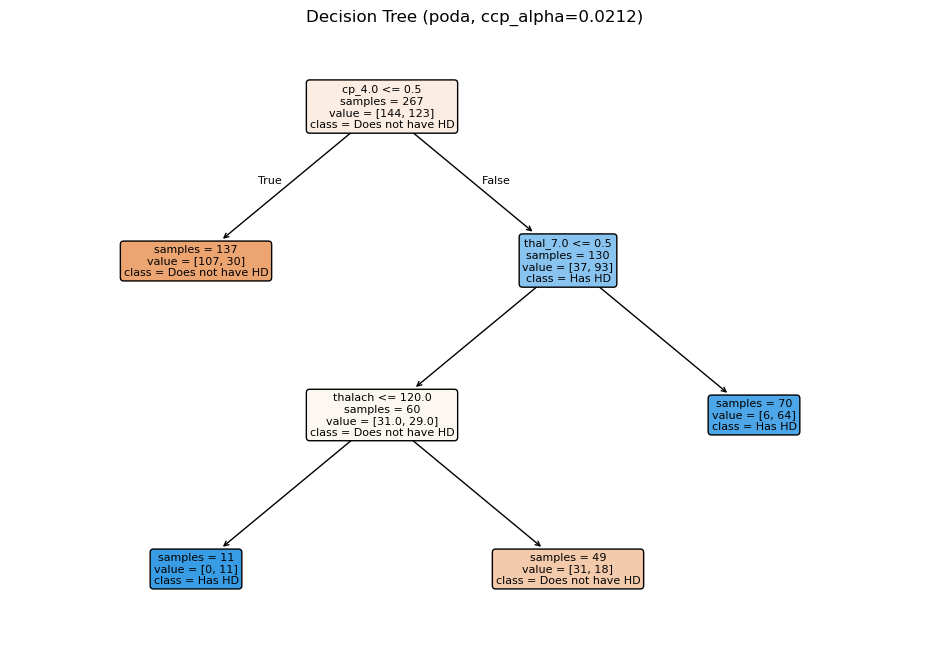

In [46]:
tree_pruned = DecisionTreeClassifier(ccp_alpha=optimal_alpha, random_state=123)
tree_pruned.fit(X_train, y_train)

plt.figure(figsize=(12,8))
_ = plot_tree(tree_pruned, feature_names=X.columns, class_names=labels,
              filled=True, rounded=True, impurity=False, fontsize=8)
plt.title(f"Decision Tree (poda, ccp_alpha={optimal_alpha:.3g})")
plt.show()


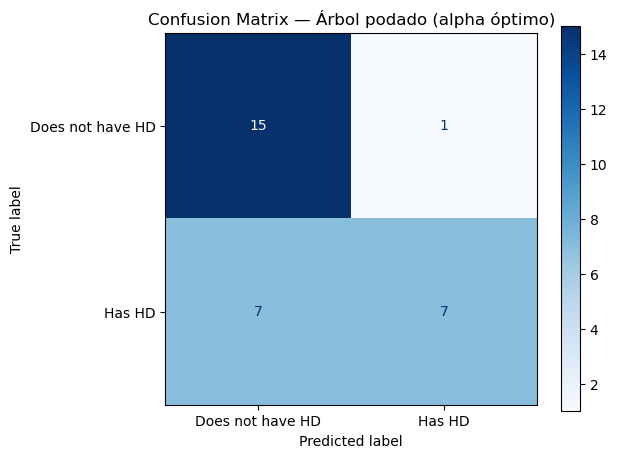

Classification report (árbol podado):
                  precision    recall  f1-score   support

Does not have HD       0.68      0.94      0.79        16
          Has HD       0.88      0.50      0.64        14

        accuracy                           0.73        30
       macro avg       0.78      0.72      0.71        30
    weighted avg       0.77      0.73      0.72        30



In [47]:
y_pred_pruned = tree_pruned.predict(X_test)
cm_pruned = confusion_matrix(y_test, y_pred_pruned)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pruned, display_labels=labels)

fig, ax = plt.subplots(figsize=(6,5))
disp2.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix — Árbol podado (alpha óptimo)")
plt.show()

print("Classification report (árbol podado):")
print(classification_report(y_test, y_pred_pruned, target_names=labels))

In [49]:
print("Predicted right:",(cm_pruned[1,1]+cm_pruned[0,0])*100/30,"   ","Predicted wrong:",(cm_pruned[0,1]+cm_pruned[1,0])*100/30)

Predicted right: 73.33333333333333     Predicted wrong: 26.666666666666668


In [51]:
acc_pruned = (y_pred_pruned == y_test).mean()
print(f"Accuracy (árbol sin poda):   {acc_unpruned:.3f}")
print(f"Accuracy (árbol podado):    {acc_pruned:.3f}")

Accuracy (árbol sin poda):   0.800
Accuracy (árbol podado):    0.733
